## Qauntum Random Walk

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit.library  import UnitaryGate
from qiskit.quantum_info import random_unitary
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from numpy import pi, array
import numpy as np

In [2]:
import qiskit
qiskit.__version__

'1.3.2'

### Define the variables

In [3]:
n = 3 # dimension of graph
n_d = int(np.ceil(np.log2(n))) # dimension of coin

In [4]:
ed = np.array([[0, 0, 0],
               [0, 0, 1],
               [0, 1, 0],
               [1, 0, 0]])

S = np.zeros((2**(n+n_d), 2**(n+n_d)))
for d in range(2**n_d):
    for x in range(2**n):
        vd = np.zeros((1, 2**n_d))
        vd[0, d] = 1
        vx = np.zeros((1, 2**n), dtype=np.int64)
        vx[0, x] = 1
        ved = np.zeros((1, 2**n), dtype=np.int64)
        ed_decimal = int("".join(map(str, ed[d])), 2)
        ved[0, np.bitwise_xor(ed_decimal, x)] = 1
        col  = np.kron(ved, vd).reshape(2**(n+n_d), 1)
        row  = np.kron(vx, vd).reshape(1, 2**(n+n_d))
        S += np.dot(col, row)
np.set_printoptions(threshold=np.inf)
S_gate = UnitaryGate(S, label='shift\noperator')

In [5]:
C = UnitaryGate(2/2**n_d*np.ones((2**n_d, 2**n_d)) - np.eye(2**n_d), label='coin')
print(C.params)

[array([[-0.5+0.j,  0.5+0.j,  0.5+0.j,  0.5+0.j],
       [ 0.5+0.j, -0.5+0.j,  0.5+0.j,  0.5+0.j],
       [ 0.5+0.j,  0.5+0.j, -0.5+0.j,  0.5+0.j],
       [ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j]])]


### Create the quantum circuit

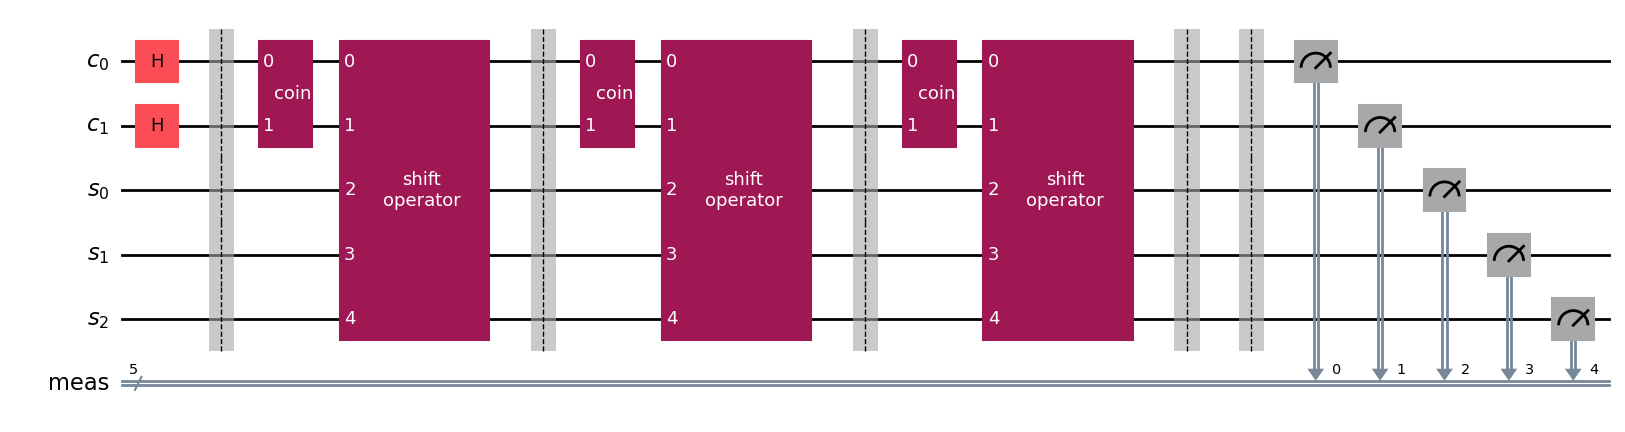

In [6]:
# Create the quantum circuit 
qc  = QuantumCircuit()
steps = 3

# Add quantum registers to the circuit
shift = QuantumRegister(n, 's') # qubits associated with the graph nodes
coin = QuantumRegister(n_d, 'c') # qubit associated with the coin
qc.add_register(coin)
qc.add_register(shift)

# Create equal superposition of coin and walker
[qc.h(coin[i]) for i in range(n_d)]
qc.barrier()
for _ in range(steps):
    qc.append(C, coin)
    # Apply the walk
    qc.append(S_gate, range(qc.num_qubits))
    qc.barrier()

# Measure the state of the walker
qc.measure_all()

# Display the quantum circuit
qc.draw('mpl', filename=f"qrw_circuit_{steps}.png")

### Simulate the circuit

In [7]:
def print_table_from_dict(mydict):
    print("----------------------------")
    print("Node\t Coin\t Probability")
    print("----------------------------")
    for count in mydict:
        print(count[0:3], '\t', count[3:5],'\t', mydict[count]/1000)
    print("----------------------------")

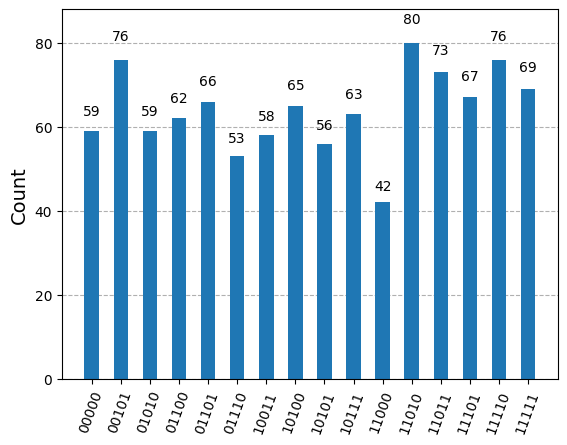

----------------------------
Node	 Coin	 Probability
----------------------------
101 	 00 	 0.065
111 	 01 	 0.067
011 	 10 	 0.053
101 	 11 	 0.063
110 	 10 	 0.08
000 	 00 	 0.059
011 	 01 	 0.066
011 	 00 	 0.062
110 	 00 	 0.042
111 	 11 	 0.069
110 	 11 	 0.073
010 	 10 	 0.059
111 	 10 	 0.076
100 	 11 	 0.058
101 	 01 	 0.056
001 	 01 	 0.076
----------------------------


In [8]:
sim_ideal = AerSimulator()
tqc = qiskit.transpile(qc, sim_ideal)
result_ideal = sim_ideal.run(tqc).result()
display(plot_histogram(result_ideal.get_counts()))

print_table_from_dict(result_ideal.get_counts())

## Graph Search In Quantum Random Walk

In [9]:
marked_state = 3
marked_state_mat = np.zeros((2**n, 2**n))
marked_state_mat[marked_state, marked_state] = 1
C1 = np.kron(np.eye(2**n), C.to_matrix()) - np.kron(marked_state_mat, (C-np.eye(2**n_d)))

C1_gate = UnitaryGate(C1,  label='marked\ncoin')
marked_state_mat

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

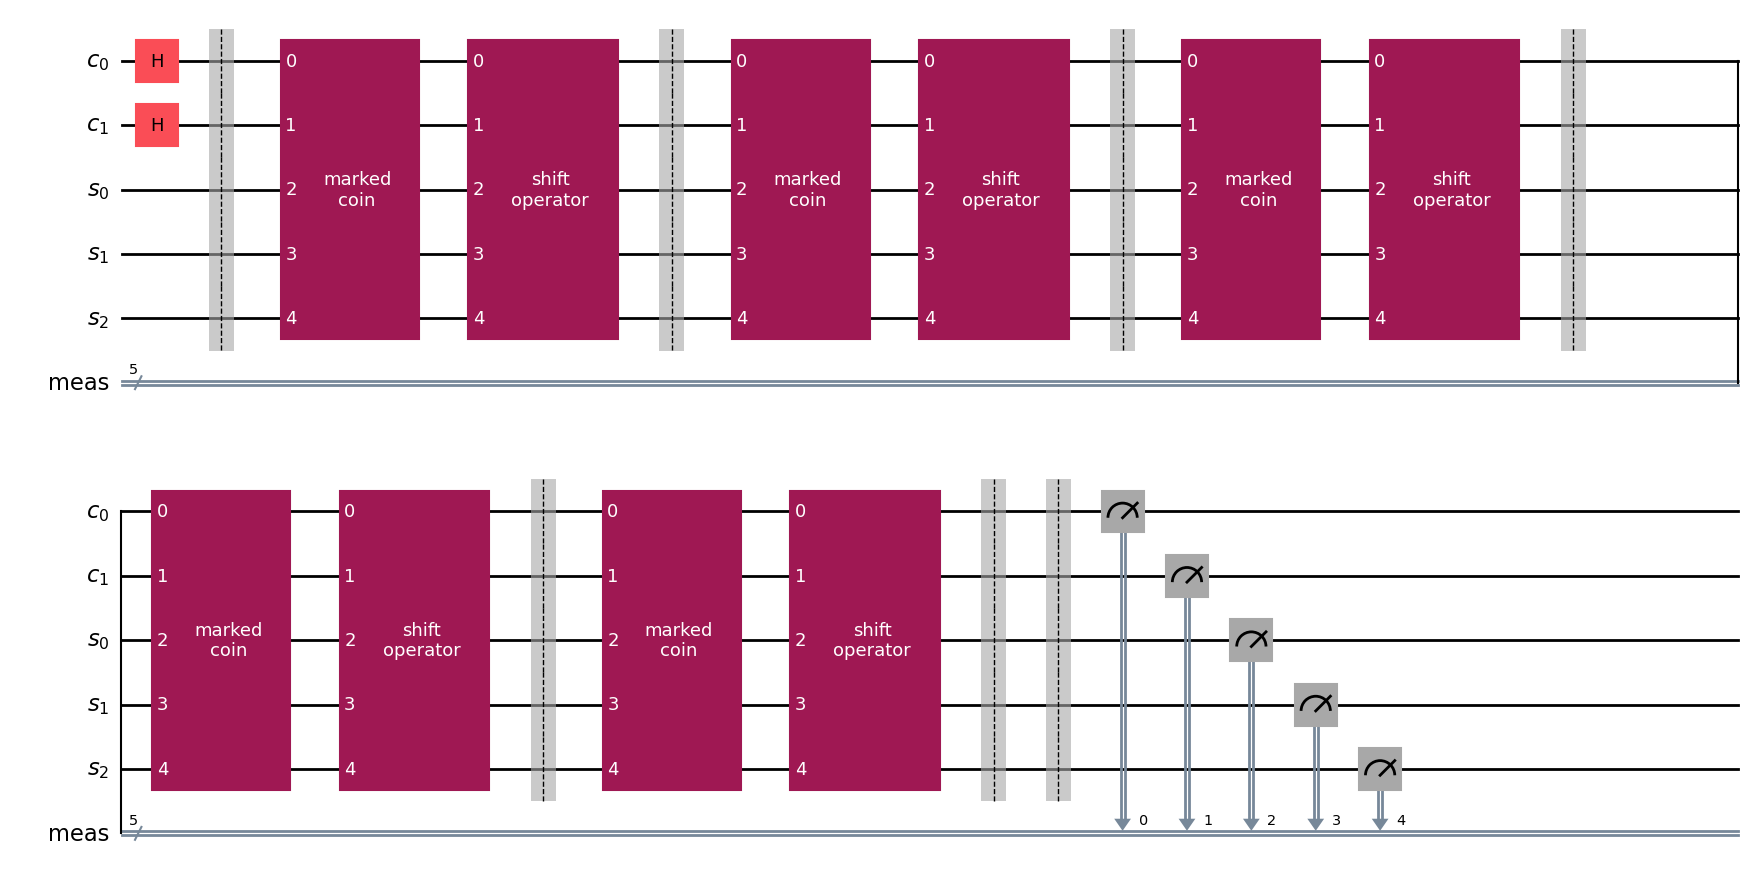

In [10]:
# Create the quantum circuit 
qc_search  = QuantumCircuit()
steps = 5

# Add quantum registers to the circuit
shift = QuantumRegister(n, 's') # qubits associated with the graph nodes
coin = QuantumRegister(n_d, 'c') # qubit associated with the coin
qc_search.add_register(coin)
qc_search.add_register(shift)

# Create equal superposition of coin and walker
[qc_search.h(coin[i]) for i in range(n_d)]
qc_search.barrier()
for _ in range(steps):
    qc_search.append(C1_gate, range(qc_search.num_qubits))
    # Apply the walk
    qc_search.append(S_gate, range(qc_search.num_qubits))
    qc_search.barrier()

# Measure the state of the walker
qc_search.measure_all()

# Display the quantum circuit
qc_search.draw('mpl',  filename="qrw_search.png")

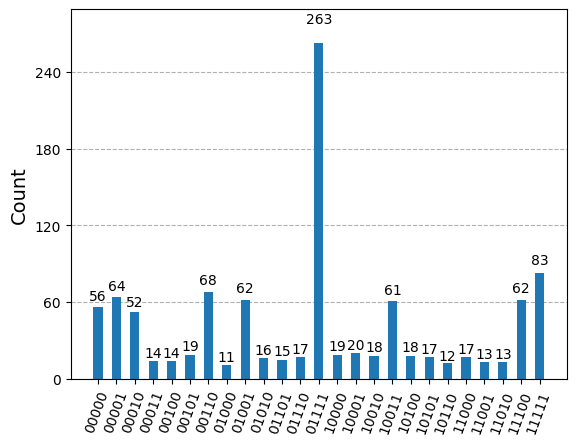

----------------------------
Node	 Coin	 Probability
----------------------------
010 	 01 	 0.062
110 	 10 	 0.013
100 	 01 	 0.02
111 	 11 	 0.083
111 	 00 	 0.062
100 	 11 	 0.061
011 	 11 	 0.263
011 	 01 	 0.015
000 	 00 	 0.056
000 	 01 	 0.064
011 	 10 	 0.017
001 	 00 	 0.014
001 	 10 	 0.068
010 	 10 	 0.016
110 	 00 	 0.017
110 	 01 	 0.013
000 	 10 	 0.052
001 	 01 	 0.019
101 	 00 	 0.018
100 	 00 	 0.019
100 	 10 	 0.018
000 	 11 	 0.014
101 	 10 	 0.012
010 	 00 	 0.011
101 	 01 	 0.017
----------------------------
Marked element: 3


In [11]:
# Run the simulation
sim_ideal = AerSimulator()
tqc_search = qiskit.transpile(qc_search, sim_ideal)
result_ideal = sim_ideal.run(tqc_search).result()
search_counts =  result_ideal.get_counts()
# Display the results
display(plot_histogram(search_counts))
# Print the simulation data
print_table_from_dict(search_counts)
# Print the marked element
max_key = max(search_counts, key=search_counts.get)
print("Marked element:", int(max_key[0:3], 2))